# SigPy for MRI Tutorial Part 2: Parallel Imaging Compressed Sensing Reconstruction

Welcome again!

In this notebook, we will run `App`s in SigPy to perform parallel imaging compressed sensing reconstruction. These iterative methods can be difficult to implement from scratch and computationally intensive. We will show how SigPy `App`s provide simple interfaces to run these reconstructions.

For a complete list of MRI `App`s, please see: https://sigpy.readthedocs.io/en/latest/mri_app.html

# Setup

MRI `App`s are separately defined in the mri submodule `sigpy.mri`. So in addition to Numpy and SigPy, we will need to import `sigpy.mri`.

In [6]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot as pl

For this notebook, we will be use an 8-channel brain dataset acquired with a Cartesian sampling. The dataset was retrospectively undersampled by 8 with a Poisson-disk undersampling mask. Let us load the dataset and visualize it:

<IPython.core.display.Javascript object>


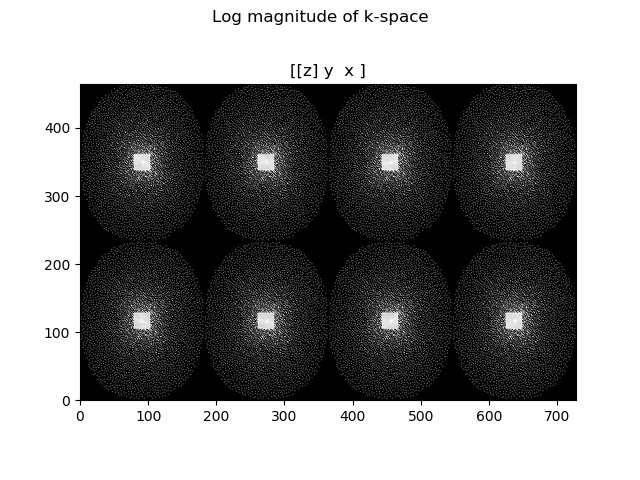

In [8]:
ksp = np.load('data/cartesian_ksp.npy')

pl.ImagePlot(ksp, mode='l', z=0, title='Log magnitude of k-space')

You can see that the dataset has a fully-sampled calibration in the center, and undersampled in a variable density fashion. Let us do a root-sum-of-squares reconstruction first to look at a zero-filled reconstruction:

<IPython.core.display.Javascript object>


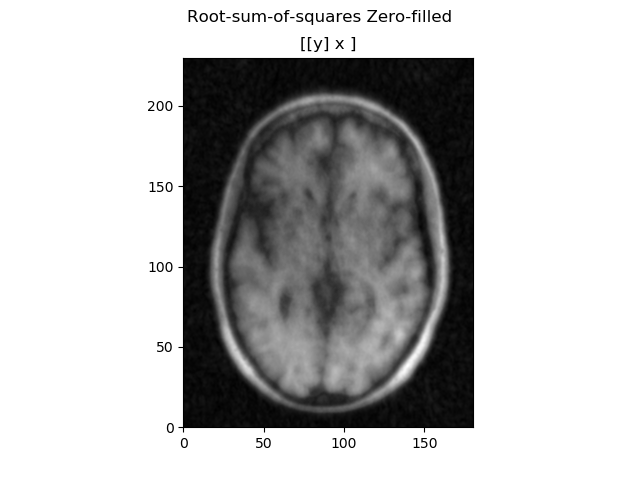

In [22]:
img_rss = np.sum(np.abs(sp.ifft(ksp, axes=(-1, -2)))**2, axis=0)**0.5

pl.ImagePlot(img_rss, title='Root-sum-of-squares Zero-filled')

Clearly the zero-filled reconstruction is not good! In the following, we will perform parallel imaging compressed sensing reconstruction using `App`s. We will first use ESPIRiT to estimate the sensitivity maps from the calibration region, then perform SENSE reconstruction, L1 wavelet regularized reconstruction, and total variation regularized reconstruction.

## Estimating sensitivity maps using ESPIRiT

To perform parallel imaging reconstruction, we will use the ESPIRiT method to estimate the sensitivity maps. To do this, we can use the [EspiritCalib](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.EspiritCalib.html#sigpy.mri.app.EspiritCalib) App. 

To run an App, you simply do `app.run()`. You should be able to see a progress bar showing the `App`'s progress. 

Note that all MRI `App`s can run on GPU by specifying the option `device`. And of course, you will first need to have a GPU and install `cupy`.

EspiritCalib: 100%|██████████| 100/100 [00:01<00:00, 70.96it/s]


<IPython.core.display.Javascript object>


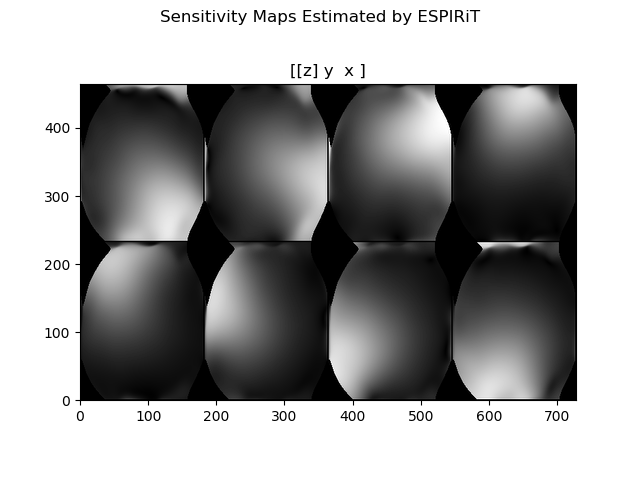

In [23]:
mps = mr.app.EspiritCalib(ksp).run()

pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')

## SENSE Recon

With the sensitivity maps ready, we can now run a SENSE reconstruction using the [SenseRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.SenseRecon.html#sigpy.mri.app.SenseRecon) `App`. We will use an l2 regularization of 0.01 based on trial-and-error with this dataset. Feel free to change it!

Again, we can run the reconstruction on GPU if we specify the `device` option.

SenseRecon: 100%|██████████| 100/100 [00:05<00:00, 18.43it/s, resid=1.92E-09]


<IPython.core.display.Javascript object>


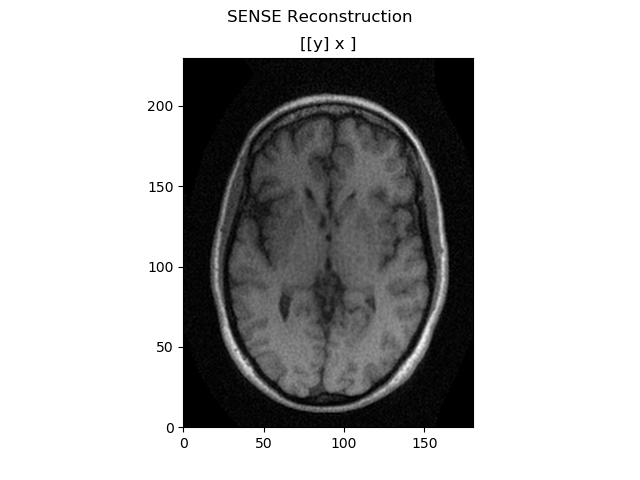

In [24]:
lamda = 0.01
img_sense = mr.app.SenseRecon(ksp, mps, lamda=lamda).run()

pl.ImagePlot(img_sense, title='SENSE Reconstruction')

## L1 Wavelet Regularized Reconstruction

Similarly, we can perform an l1-wavelet regularized reconstruction using [L1WaveletRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.L1WaveletRecon.html#sigpy.mri.app.L1WaveletRecon).

L1WaveletRecon: 100%|██████████| 100/100 [00:06<00:00, 16.57it/s, resid=1.26E-03]


<IPython.core.display.Javascript object>


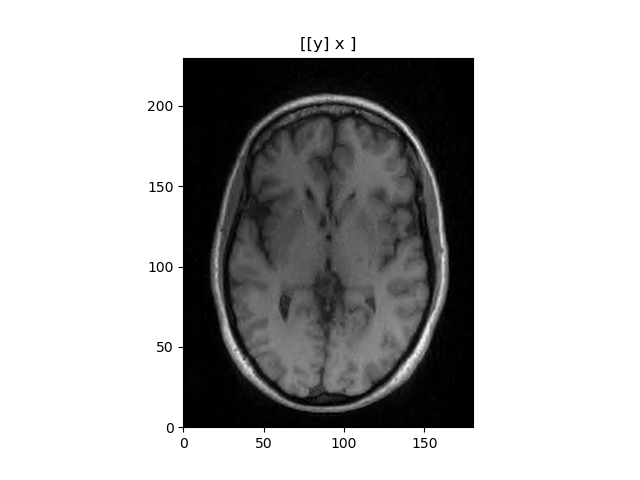

In [25]:
lamda = 0.005
img_l1wav = mr.app.L1WaveletRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_l1wav, title='L1 Wavelet Regularized Reconstruction')

# Total Variation Recon

And we can do total variation regularized reconstruction with [TotalVariationRecon](https://sigpy.readthedocs.io/en/latest/generated/sigpy.mri.app.TotalVariationRecon.html#sigpy.mri.app.TotalVariationRecon).

TotalVariationRecon: 100%|██████████| 100/100 [00:09<00:00, 10.41it/s, resid=9.53E-03]


<IPython.core.display.Javascript object>


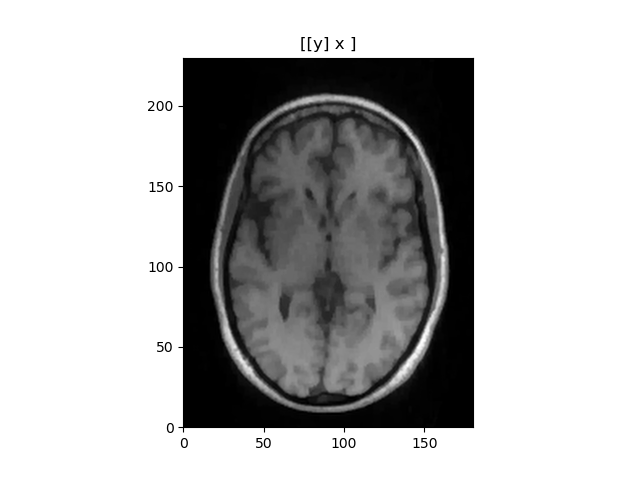

In [26]:
lamda = 0.005
img_tv = mr.app.TotalVariationRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_tv, title='Total Variation Regularized Reconstruction')

And this is how you can do parallel imaging compressed sensing reconstruction with SigPy! We haven't gone through non-Cartesian datasets, but non-Cartesian support can be enabled by passing k-space coordinates to the `coord` option.

In [part 3](03-building-an-l1-wavelet-recon-app.ipynb), we will expose the inner workings of these `App`, and show how you can easily build your own `App`!